## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: Friday 31 May 2019 9am EST US
* Instructor name: Jeff Herman
* Blog post URL:

# A Perceptron of the Artist as a Young Man

Can a computer appreciate a piece of literature? I'd like to train a model that can identify the main conceit of the James Joyce novel *A Portrait of the Artist as a Young Man*. 

I've taken the data from the [Project Gutenberg](https://www.gutenberg.org/ebooks/4217).

**From chapter 1**:

     Rody Kickham was a decent fellow but Nasty Roche was a stink. Rody
     Kickham had greaves in his number and a hamper in the refectory. Nasty
     Roche had big hands. He called the Friday pudding dog-in-the-blanket.

Short phrases, repetitive; the surface-level observations of a small child.

**From chapter 2**:

     Very good, Simon. All serene, Simon, said the old man tranquilly. 
     Anywhere you like. The outhouse will do me nicely: it will be more 
     salubrious. 

The earnest, fluent, wide-eyed observations of an older child.

**From chapter 3**:

    The swift December dusk had come tumbling clownishly after its dull day 
    and as he stared through the dull square of the window of the 
    schoolroom he felt his belly crave for its food. He hoped there would 
    be stew for dinner, turnips and carrots and bruised potatoes and fat 
    mutton pieces to be ladled out in thick peppered flour-fattened sauce.

The high drama and insaiable hunger of a teenager.

**From chapter 4**:

    But he could no longer disbelieve in the reality of love, since God 
    himself had loved his individual soul with divine love from all 
    eternity. Gradually, as his soul was enriched with spiritual knowledge, 
    he saw the whole world forming one vast symmetrical expression of God's 
    power and love.

The obsessive single-mindedness of a cerebral young student of religion.

**From chapter 5**:

    Art, said Stephen, is the human disposition of sensible or 
    intelligible matter for an esthetic end. You remember the pigs and 
    forget that. You are a distressing pair, you and Cranly. 

The arrogance and irony of one's 20s.

The effect of the book as one reads it is of an inexorable growth  of the protagonist's mind as he matures. His interests shift, his attitudes turn: he grows. The book *shows* the growth through its control of the language. A human reader can pick up on the changes from one chapter to another. Could a classification algorithm do the same in its own way?

# Contents
- Libraries
- Exploratory Data Analysis
  - [Words or sentences?](#wordsorsentences)
    - [Words](#words)
    - [Sentences](#sentences)
    - [Other features](#otherfeatures)
    - [Findings](#edafindings)
- Modeling
  - [Logistic regression](#lr)
  - [Random forests](#rf)
  - [Deep neural networks](#nn)
- [Conclusions](#conclusions)

# Libraries

In [1]:
#Custom functions
import joyce_functions
from joyce_functions import stop, word_vec_df, sent_vec_df, appears_in, \
                            vec_to_col, do_pca, get_xyz, plot_pca, isolate, draw_prism, \
                            prepare, lr, rf, plot_conf_matrix, plot_nn

import copy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For viewing 3d pca feature plots
import seaborn as sns

#For NLP preprocessing
from nltk.corpus import stopwords
from nltk import word_tokenize
import string #for removing punctuation from text
import en_core_web_md #parrish
import spacy #parrish 

# MODELING:
from sklearn.decomposition import PCA #For squashing word vector means
from sklearn.preprocessing import StandardScaler #For normalizing data
#To divide data when testing a trained model
from sklearn.model_selection import train_test_split 
#To build regular logistic regression models
from sklearn.linear_model import LogisticRegression
# ENSEMBLE METHODS:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# ASSESSING MODELS:
#To assess accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
#To iteratively append labels to cells in a confusion matrix
import itertools 
#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report

#For neural network preprocessing
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, GlobalMaxPool1D, GlobalMaxPool2D, GRU
from keras.models import Model
from keras import models, initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [2]:
#Needed for first time use on each machine:
#import nltk
#nltk.download('stopwords')

<a id = 'top'></a>

# Exploratory data analysis

## Reading in the data

I've used a work flow created by Allison Parrish in her [excellent tutorial](https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469) on word embeddings.

The text of each chapter gets read as a Spacy document. I then call custom functions on each chapter to turn into a DataFrame of word vectors or sentence vectors. Stop words get dropped and the remaining words become tokens. Each token gets assigned a 300 vector dimensions, taken from Word2Vec. The DataFrame of sentence vectors also gets some new features engineered in to track the length and number of words in each sentence.

In [3]:
# Read in the data as spacy documents
nlp = spacy.load('en_core_web_md')

with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = nlp(f1.read())
    ch2 = nlp(f2.read())
    ch3 = nlp(f3.read())
    ch4 = nlp(f4.read())
    ch5 = nlp(f5.read())

#Turn words into tokens, tokens into vectors, and build dfs
wv_df1 = word_vec_df(ch1, 1)
wv_df2 = word_vec_df(ch2, 2)
wv_df3 = word_vec_df(ch3, 3)
wv_df4 = word_vec_df(ch4, 4)
wv_df5 = word_vec_df(ch5, 5)
wv_df = wv_df1.append([wv_df2, wv_df3, wv_df4, wv_df5])

#Turn sentences into token lists, token lists into vector lists, and build dfs
sv_df1 = sent_vec_df(ch1, 1)
sv_df2 = sent_vec_df(ch2, 2)
sv_df3 = sent_vec_df(ch3, 3)
sv_df4 = sent_vec_df(ch4, 4)
sv_df5 = sent_vec_df(ch5, 5)
sv_df = sv_df1.append([sv_df2, sv_df3, sv_df4, sv_df5], ignore_index = True)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
wv_df.head()

,token,vector,label
0,lands,"[0.16868, -0.29736, -0.42247, 0.091817, -0.221...",1
1,riordan,"[0.3072, 0.0409, -0.5815, 0.23447, 0.2023, 0.0...",1
2,shivery,"[0.10362, -0.16763, 0.040108, 0.099834, -0.077...",1
3,catafalque,"[0.47753, -0.69251, -0.22674, -0.17166, 0.0080...",1
4,march,"[0.36049, 0.1952, 0.41292, 0.33963, 0.19575, -...",1


In [5]:
sv_df.head()

,sentence,char_count,token,mean_token_len,token_count,vectors,vector,label
0,Once upon a time and a very good time it was t...,143,"[upon, time, good, time, moocow, coming, along...",4.833333,12,"[[0.14861, -0.31427, -0.37246, -0.26593, -0.32...","[0.16427054, 0.12741734, -0.063235335, -0.1478...",1
1,met a nicens little boy named baby tuckoo....\n\n,47,"[met, nicens, little, boy, named, baby, tuckoo]",4.714286,7,"[[0.17151, 0.2361, -0.091475, -0.12491, 0.0446...","[-0.035361428, 0.11802828, -0.28247643, 0.0138...",1
2,His father told him that story: his father loo...,96,"[father, told, story, father, looked, glass, h...",5.125000,8,"[[0.07836, 0.24624, -0.13153, 0.25374, 0.21725...","[-0.1338875, -0.10129124, -0.16580924, 0.22228...",1
3,He was baby tuckoo.,19,"[baby, tuckoo]",5.000000,2,"[[-0.1445, 0.32683, -0.62883, 0.18326, 0.27117...","[-0.07225, 0.163415, -0.314415, 0.09163, 0.135...",1
4,The moocow came down the road where Betty Byrn...,82,"[moocow, came, road, betty, byrne, lived, sold...",4.777778,9,"[[-0.0090117, 0.010151, 0.67677, -0.46424, -0....","[0.07056996, 0.28936455, 0.14651866, -0.130147...",1


<a id = 'wordsorsentences'></a>

# Words or sentences?

It may be more straightforward to run models using words as vectors but I have a hunch that this will be less meaningful and less useful than using sentences. If a model can place a whole sentence in the context of its chapter then more meaning will be conveyed than just placing a word within a chapter. We'll still examine word vectors first, just to see.

<a id = 'words'></a>

## Exploring words as vectors

Each word has its own 300-dimension vector as calculated by Word2Vec. This makes it impossible to visualize the vectors without boiling them down into 2 or 3 dimensions. We'll use principal component analysis to choose the the most important (highest-variance) dimensions of the vectors so that each word can be shown across 'space' and across 'time.'

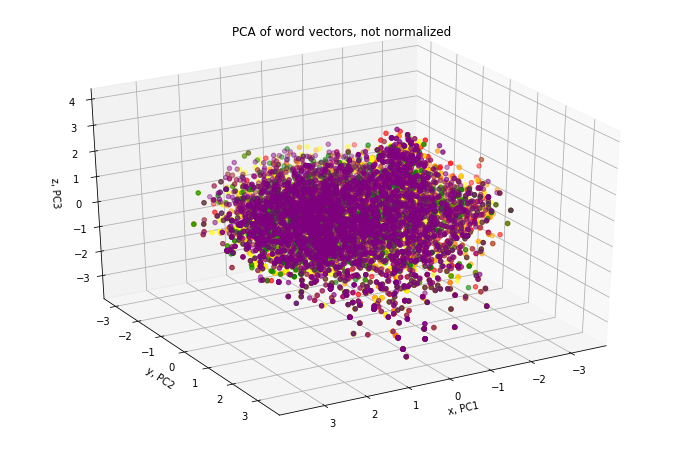

In [6]:
byword_pca = do_pca(wv_df)

#Plot PCA of word vectors together
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]

plot_pca(byword_pca, plot_list, figsize = (12, 8), title = 'PCA of word vectors, not normalized')

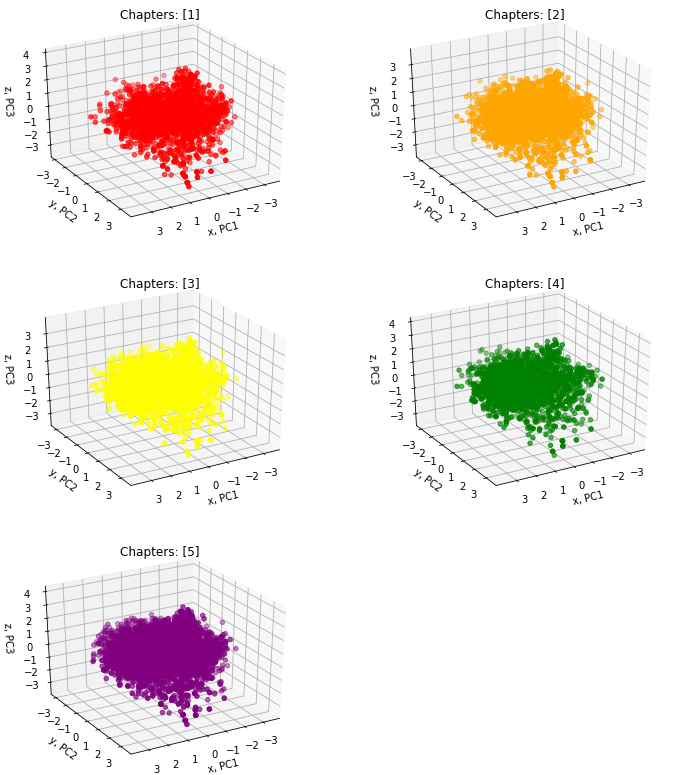

In [7]:
#Show each chapter as its own plot
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]

plot_pca(byword_pca, plot_list)

### Observations:

When viewed across 'space,' the word vectors don't seem to be clustering in a meaningful way. It might be helpful to look at only the words that are unique to each chapter.

## Unique words

In [8]:
zeros = np.zeros(300)
#Get unique word vectors from each chapter
unique1 = appears_in(wv_df, wv_df1, 1)
unique2 = appears_in(wv_df, wv_df2, 2)
unique3 = appears_in(wv_df, wv_df3, 3)
unique4 = appears_in(wv_df, wv_df4, 4)
unique5 = appears_in(wv_df, wv_df5, 5)

#Drop the empty vectors 
uniq1_notna = unique1[[False if np.all(row == zeros) else True for row in unique1['vector']]]
uniq2_notna = unique2[[False if np.all(row == zeros) else True for row in unique2['vector']]]
uniq3_notna = unique3[[False if np.all(row == zeros) else True for row in unique3['vector']]]
uniq4_notna = unique4[[False if np.all(row == zeros) else True for row in unique4['vector']]]
uniq5_notna = unique5[[False if np.all(row == zeros) else True for row in unique5['vector']]]

In [9]:
#PCA for unique vectors, excluding empty vectors
unique_notna = uniq1_notna.append([uniq2_notna, uniq3_notna, uniq4_notna, uniq5_notna])
unique_notna_pca = do_pca(unique_notna)

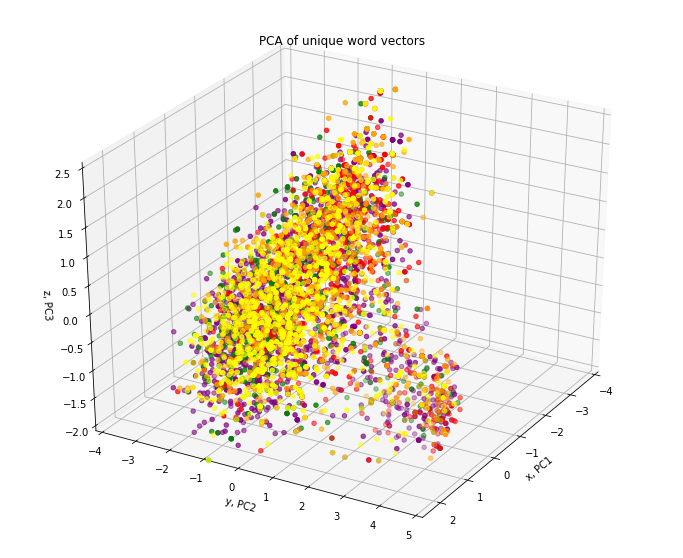

In [10]:
#Plot PCA of  unique word vectors together. Excludes NA vectors
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 30, figsize = (12,10), 
         title = 'PCA of unique word vectors')

### Observations:

Strong upward linear thrust among all words in all chapters. Very clear that a classifier won't be able to distinguish them. But there's something else...

### What's that blob in the corner?

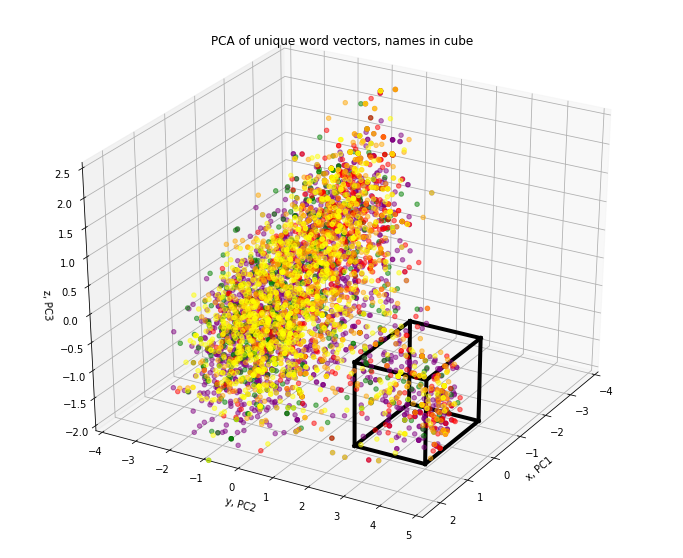

In [11]:
prismXYZ = {'names': [-1, 1, 2, 4, -2, -0.5]}
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 30, alpha = 0.5, figsize = (12,10), 
         prismXYZ = prismXYZ, title = 'PCA of unique word vectors, names in cube')

In [12]:
#What's that blob in the corner?  

blob = isolate(unique_notna_pca, xyz = prismXYZ['names'])
blob[blob['label'] == 3]

,PC1,PC2,PC3,token,vector,label
1529,-0.257728,2.934524,-1.590606,juxta,"[0.2894, -0.071284, 0.042493, -0.23823, -0.147...",3
1591,-0.174834,2.924922,-1.032737,harbringer,"[0.46099, -0.030256, 0.46265, -0.28196, -0.124...",3
1622,-0.246145,2.258567,-1.173976,rheum,"[0.19672, 0.028268, 0.5576, -0.12848, -0.67843...",3
1726,0.019807,2.306283,-1.541923,sicut,"[-0.3953, -0.29947, 0.26086, -0.10656, -0.1290...",3
1739,-0.582552,2.741367,-1.232146,cedrus,"[0.46446, -0.67028, 0.36325, 0.4744, -0.16703,...",3
1831,-0.246145,2.258567,-1.173976,boundlessness,"[0.19672, 0.028268, 0.5576, -0.12848, -0.67843...",3
1977,-0.605417,2.042784,-1.268706,thrones,"[0.11034, -1.1992, 0.064216, 0.11611, -0.47778...",3
1988,-0.436760,3.425319,-1.236717,surd,"[0.94471, 0.47677, 0.020622, 0.35398, 0.055051...",3
2041,-0.246145,2.258567,-1.173976,illgotten,"[0.19672, 0.028268, 0.5576, -0.12848, -0.67843...",3
2088,0.635675,2.336467,-1.189810,lucifer,"[-0.25238, -0.28252, 0.62997, -0.76729, -0.080...",3


### Observations:

The blob in the corner has a cluster of words that are all similar to each other in some way. The particular similarity seemed to change when I re-ran PCA but it was striking each time.

### Other 'blobs of meaning'

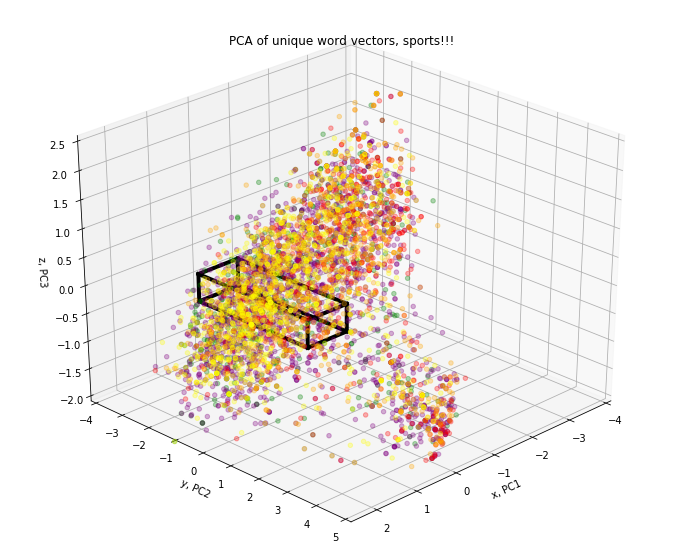

In [13]:
#Sports!!! Flags, winning, games
xyz = [-1, 0, -4, 0, -1, -0.5]
sports = isolate(unique_notna_pca, xyz)

prismXYZ = {'sports': [-1, 0, -4, 0, -1, -0.5]}
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 45, alpha = 0.3, figsize = (12,10), 
         prismXYZ = prismXYZ, title = 'PCA of unique word vectors, sports!!!')

In [14]:
sports['token']

166          drivers
184          cricket
227           digest
232             flag
351           cancer
367             bets
380            badge
391          riddles
407        unlocking
466         holidays
506          holders
666           latest
853         aromatic
854            party
924          anatomy
940            prize
1046         sellers
1058        southern
1072           build
1088          market
1105         section
1154          prizes
1166          moiety
1195    respectively
1197       broadened
1202      cricketers
1241          manned
1253        stations
1308          player
1319         trainer
            ...     
3732          eleven
3802           fused
3878         contact
3899          choose
3909          refine
4007     photographs
4048       orchestra
4064         applied
4094           usage
4107       preferred
4154         version
4155        thirteen
4200            uses
4321         seaport
4350           hedge
4358           brand
4451       ma

In [15]:
#More blobs of meaning:

#Government, politics, nations, courts
#Very few in chapter 1, a lot in chapter 5
gov = [0, 3, -4, 0, -1.5, -1]

#Commercial buildings, waterfront
water = [-3, -1, -4, 0, -1, -0.5]

#Stuff: nouns, very few verbs
stuff = [-2, -1, -4, 0, -0.5, -0]

#A lot of verbs here, present tense not continuous
verbs = [0, 0.5, -4, 0, 0, 0.5]

#-ing verbs, but not in chapter 5
ing = [-0.5, 0, -4, 0, 0, 0.5]

#Short words?
short = [-1, -0.5, -4, 0, 0, 0.5]

#plural nouns
plural = [-3, -1, -4, 0, 0, 0.5]

#-ed verbs (past tense)
ed = [-0.5, 2, -4, 0, 0.5, 1]

#a lot of short plural nouns and verbs
moreshort = [-2.5, -0.5, -4, 0, 0.5, 1]

#fabric and food
fabric = [-3, -2.5, -4, 0, 0.5, 1]

#negative feelings
neg = [0.5, 2, -4, 0, 1, 1.5]

#oceanfaring verbs, ocean weather
ocean = [-1.5, 0, -4, 0, 1, 1.5]

#thigns in a house: food, junk, textures
things = [-3.5, -1.5, -4, 0, 1, 1.5]

#More negative ing verbs
neging = [-1, 2, -4, 0, 1.5, 2]

#Textures, descriptions of light
light = [-2.5, -1, -4, 0, 1.5, 2]

#twisting, coiling
twist = [-1, 2, -4, 0, 2, 2.5]

### Final observations:

Word vectors have an interesting subtle arrangement but the overall upward linear trend in the data suggests that classes won't be distinguishable. Better to move forward with sentences as vectors.

<a id = 'sentences'></a>

## Sentences as vectors

We can view the sentence vectors in 2D with PCA, and plot them against a third dimension of 'time.' This is really just the order that the sentences appear in the data set and in the book. (The book is chronological so its linear order is also temporal.)

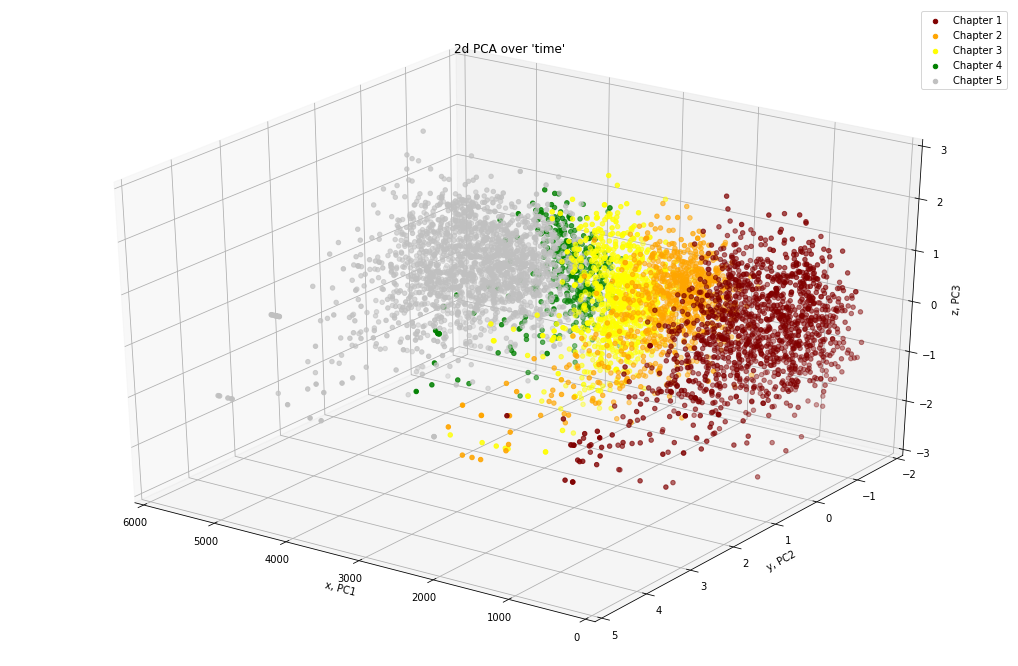

In [16]:
#2D PCA for sentence vectors
pca_df = do_pca(sv_df, components = 2)

#Adjust columns to work with plot_pca function
pca_df.rename({'PC2': 'PC3', 'PC1': 'PC2'}, axis = 1, inplace = True)
pca_df['PC1'] = pca_df.index

plot_list = [{1: 'maroon', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'silver'}]
xyz = (0, 6000, -2, 5, -3, 3)

plot_pca(pca_df, plot_list, 
             xyz = xyz,
             figsize = (18, 12),
             azim = -235, 
             elev = 30,
             alpha = None,
             prismXYZ = None,
             legend = True,
             title = '2d PCA over \'time\'')

### Observations: 

Here 'time' moves from right to left (because it looked clearer than the other way.) Chapter 4 is distinguishable not just for its short length but for its tight spread. Chapters 1 and 5 both sprawl up and out. These sentence vectors already appear more 'expressive' than the word vectors in that their vector components have more variation.

## 3D PCA sentence vectors

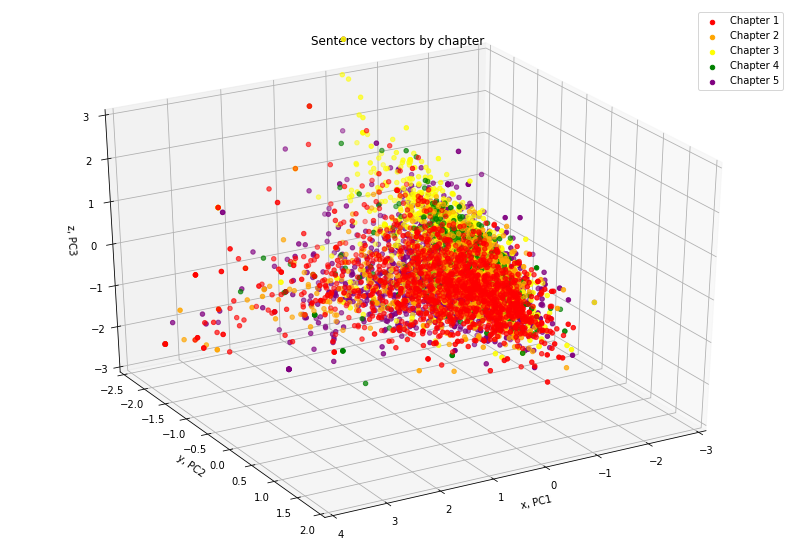

In [17]:
#Get 3D PCA for this df
pca_df = do_pca(sv_df)

xyz = [-3, 4, -2.5, 2, -3, 3]
title = 'Sentence vectors by chapter'
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]

#Plot chapters together to see distribution of PCA in 3d
plot_pca(pca_df, plot_list, xyz = xyz, figsize = (14,10), 
          legend = True, title = title)

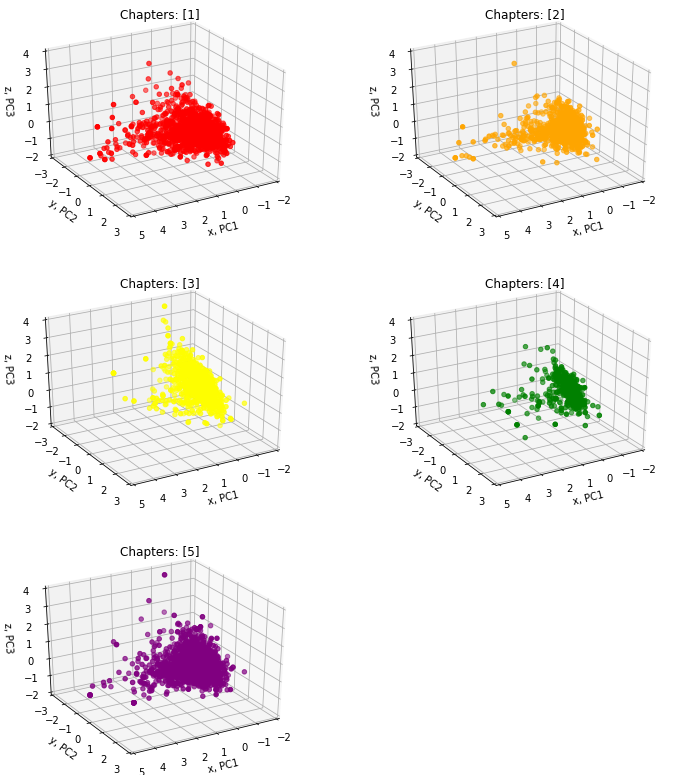

In [18]:
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]
xyz = [-2, 5, -3, 3, -2, 4]

#Draw separate plots for sentence vectors in each chapter
plot_pca(pca_df, plot_list, xyz = xyz)

### Final observations:

We can see here differences in the 'mean sentence vectors' from one chapter to another. Chapter 4 is not only smaller but also tighter. Chapter 3 spreads 'up' the most. 1 and 5 sprawl outward the most.

I'm concerned that the differentiation we see here won't be enough for a model to work with, but we'll have to build models to find out.

What about the features we engineered from the text?

<a id ='otherfeatures'></a>

## Other features: character count

Text(0.5, 1.0, 'Character counts of each sentence, by chapter')

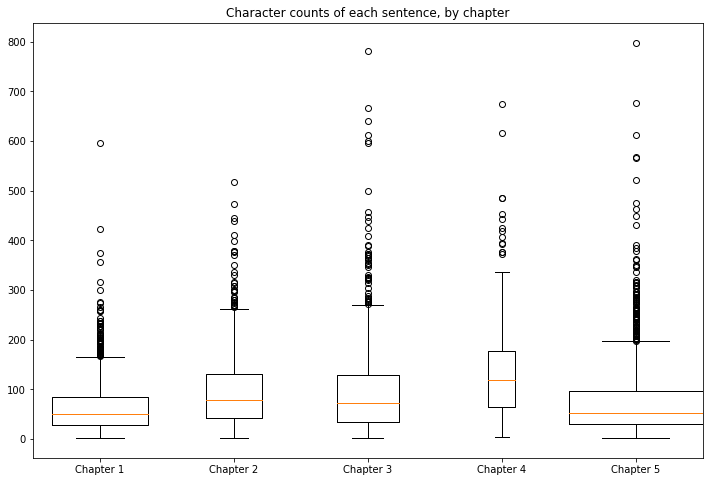

In [19]:
#Box and whisker plots
#Widths of boxes are lengths of chapters in proportion to Chapter 5.
box_widths = [sv_df1['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df2['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df3['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df4['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df5['char_count'].shape[0] / sv_df5['char_count'].shape[0]
]
#Labels for box and whisker plots
box_labels = ['Chapter 1', 'Chapter 2', 'Chapter 3', 'Chapter 4', 'Chapter 5']

#First box and whisker plot
#Chapter 4 has the longest sentences overall.
#Widths of boxes are lengths of chapters in proportion to Chapter 5.

fig = plt.figure(figsize = (12, 8))
plt.boxplot([sv_df1['char_count'],
             sv_df2['char_count'],
             sv_df3['char_count'],
             sv_df4['char_count'],
             sv_df5['char_count']
            ], 
            labels = box_labels,
            widths = box_widths
           )
plt.title('Character counts of each sentence, by chapter')

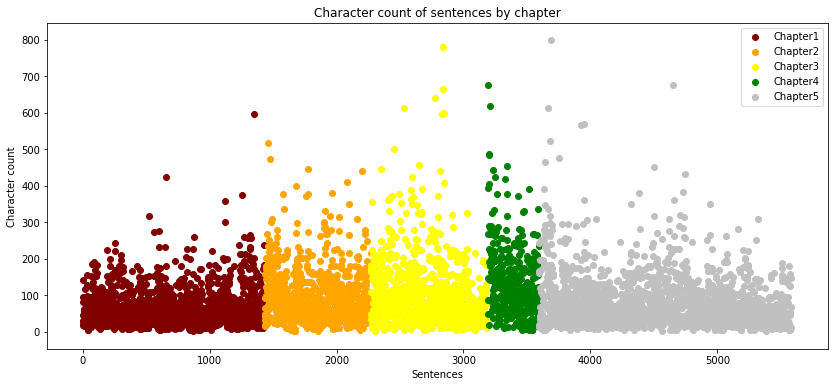

In [20]:
#Character count over "time"
plot_list = [{1: 'maroon', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'silver'}]
fig = plt.figure(figsize = (14, 6))
for key, val in plot_list[0].items():
    plt.scatter(sv_df[sv_df['label'] == key].index, #x axis 
                sv_df[sv_df['label'] == key]['char_count'], #y axis
                label = 'Chapter' + str(key),
               color = val)
plt.xlabel('Sentences')
plt.ylabel('Character count')
plt.legend()
plt.title('Character count of sentences by chapter')
plt.show()

### Observations:

The clearest trend is that the mean character count is highest in chapter 4. This suggests that it contains the longest sentences overall.

## Mean token length

Text(0.5, 1.0, 'Mean token length for each sentence, by chapter')

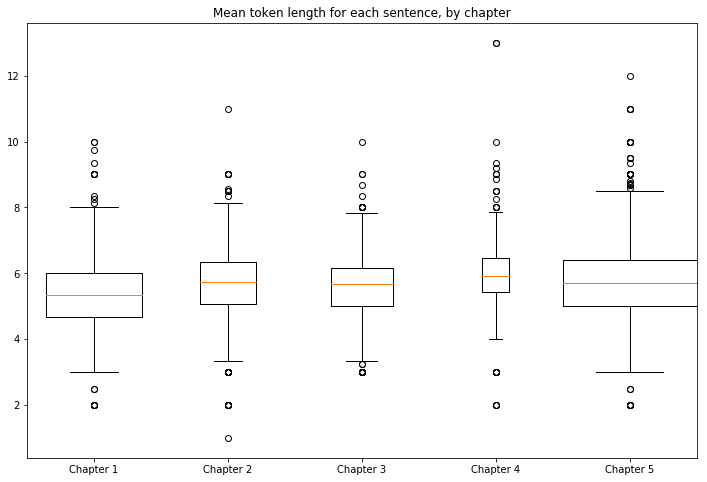

In [21]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([sv_df1['mean_token_len'],
             sv_df2['mean_token_len'],
             sv_df3['mean_token_len'],
             sv_df4['mean_token_len'],
             sv_df5['mean_token_len']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.title('Mean token length for each sentence, by chapter')

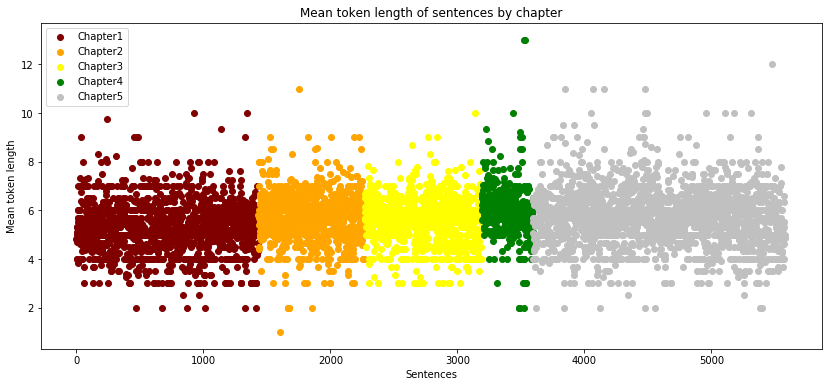

In [22]:
# Mean token length over "time"

fig = plt.figure(figsize = (14, 6))
for key, val in plot_list[0].items():
    plt.scatter(sv_df[sv_df['label'] == key].index, #x axis 
                sv_df[sv_df['label'] == key]['mean_token_len'], #y axis
                label = 'Chapter' + str(key),
               color = val)
plt.xlabel('Sentences')
plt.ylabel('Mean token length')
plt.legend()
plt.title('Mean token length of sentences by chapter')
plt.show()

### Observations:

The horizontal streaking reflects the discrete distribution of the data, e.g. (5 tokens, 6 tokens.) I'm disappointed that the distribution is so consistent across the  chapters.

## Token count

Text(0.5, 1.0, 'Token count of each sentence, by chapter')

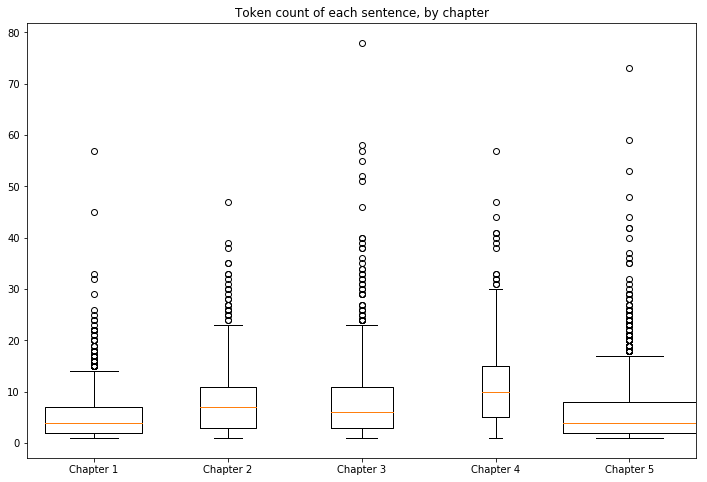

In [23]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([sv_df1['token_count'],
             sv_df2['token_count'],
             sv_df3['token_count'],
             sv_df4['token_count'],
             sv_df5['token_count']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.title('Token count of each sentence, by chapter')

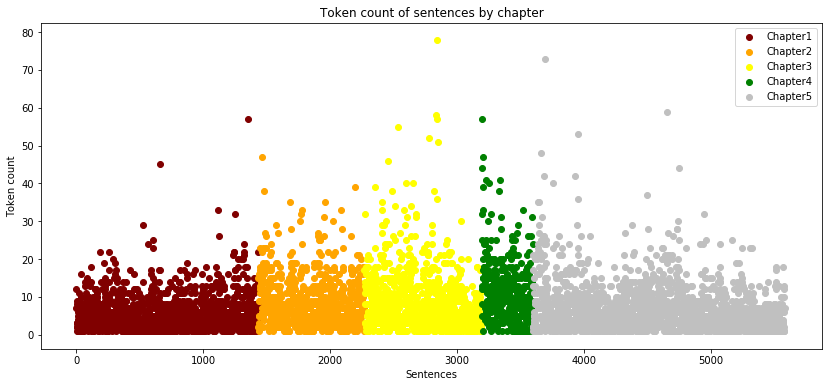

In [24]:
#Token count over "time"
fig = plt.figure(figsize = (14, 6))
for key, val in plot_list[0].items():
    plt.scatter(sv_df[sv_df['label'] == key].index, #x axis 
                sv_df[sv_df['label'] == key]['token_count'], #y axis
                label = 'Chapter' + str(key),
               color = val)
plt.xlabel('Sentences')
plt.ylabel('Token count')
plt.legend()
plt.title('Token count of sentences by chapter')
plt.show()

### Observations:

Sentences in chapter 4 have longer words. This corresponds to the character count finding. Not too encouraged overall by similar the counts are across chapters.

<a id = 'edafindings'></a>

## Final observations for exploratory data analysis:

Word vectors clearly won't work for a model. Sentence vectors display an interesting expressiveness in 3D very different from what the word vectors show. This is more promising for a model. If they don't work either, though, we may have to abandon the Parrish workflow and use another method for word embeddings.

<a id = 'lr'></a>

[(Back to top)](#top)

# Modeling

It's time to run models on our data. A simple model is often good enough, so we'll start with a classic logistic regression classifier.

# Logistic regression #1

Our sample sizes are unequal so we'll need to even them out. Chapter 4 is the shortest chapter. We can fluff it up a little. Chapters 1 and 5 are the longest so we can trim them down.

In [25]:
#Dict to store scores
all_scores = {}

In [26]:
#First stesp is to adjust sample sizes for the classes
sv_df1.shape[0], sv_df2.shape[0], sv_df3.shape[0], sv_df4.shape[0], sv_df5.shape[0]

(1433, 836, 922, 403, 1985)

In [27]:
#Down-sample chapters 1 and 5
sv1_sample = sv_df1.sample(900, replace = False)
sv5_sample = sv_df5.sample(900, replace = False)
#Up-sample chapter 4 by doubling it
sv4_sample = sv_df4.append(sv_df4, ignore_index = True)

#Combine sentence vectors dfs into one
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Logistic regressio model
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 3,
                                           normalize_vector = True,
                                           features_to_norm = None,
                                           other_features = None)

lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.31      0.47      0.37       668
           2       0.26      0.19      0.22       659
           3       0.37      0.63      0.47       678
           4       0.28      0.18      0.22       599
           5       0.30      0.12      0.17       669

   micro avg       0.32      0.32      0.32      3273
   macro avg       0.30      0.32      0.29      3273
weighted avg       0.31      0.32      0.29      3273

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.32      0.45      0.37       232
           2       0.18      0.16      0.17       177
           3       0.42      0.64      0.50       244
           4       0.34      0.20      0.25       207
           5       0.36      0.15      0.21       231

   micro avg       0.34      0.34      0.34      1091
   macro avg       0.32      0.32      0.30      1091
weighted avg       0.33      0.34 

(0.32019553926061717, 0.3354720439963336)

In [28]:
#Add score to dict
all_scores['LR #1'] = 0.33

### Observations:

Not much better than random guessing. I wonder if the features I engineered would perform well on their own.

## Logistic regression #2: no vectors, just engineered features

In [29]:
#Combine sentence vectors dfs into one
columns = ['char_count', 'mean_token_len', 'token_count', 'label']
other_features = ['char_count', 'mean_token_len', 'token_count']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Logistic regressio model
X_train, X_test, y_train, y_test = prepare(sv_df, 
                                           normalize_vector = False, 
                                           features_to_norm = None, 
                                           other_features = other_features)

y_hat_train, y_hat_test = lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.58      0.02      0.03       668
           2       0.23      0.01      0.03       659
           3       0.22      0.21      0.21       678
           4       0.33      0.40      0.36       599
           5       0.25      0.70      0.37       669

   micro avg       0.26      0.26      0.26      3273
   macro avg       0.32      0.27      0.20      3273
weighted avg       0.32      0.26      0.20      3273

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.67      0.02      0.03       232
           2       0.22      0.01      0.02       177
           3       0.23      0.20      0.22       244
           4       0.32      0.37      0.34       207
           5       0.24      0.66      0.36       231

   micro avg       0.26      0.26      0.26      1091
   macro avg       0.34      0.25      0.19      1091
weighted avg       0.34      0.26 

In [30]:
#Add score to the dict
all_scores['LR #2'] = 0.22

### Observations:
These features may help a model using sentence vectors but are no better than random guessing on their own.

## Logistic regression #3: principal component iteration

In [31]:
#Combine sentence vectors dfs into one
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

In [32]:
components = np.arange(5, 275, 10)
train_scores = []
test_scores = []

for n in components:
    X_train, X_test, y_train, y_test = prepare(sv_df, pca_components = n,
                                               normalize_vector = True,
                                               features_to_norm = None,
                                               other_features = None)
    train_score, test_score = lr(X_train, X_test, y_train, y_test, report = False)
    #Record scores for each model
    train_scores.append(train_score)
    test_scores.append(test_score)


C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-pac

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-pac

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-pac

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 1.0, 'Logistic regression with varying principal components')

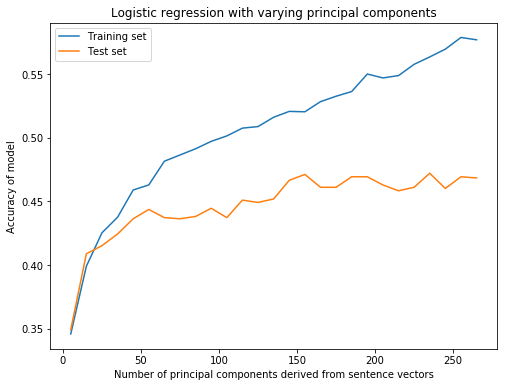

In [33]:
fig = plt.figure(figsize = (8, 6))
plt.plot(components, train_scores, label = 'Training set')
plt.plot(components, test_scores, label = 'Test set')
plt.xlabel('Number of principal components derived from sentence vectors')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Logistic regression with varying principal components')

In [34]:
#Add scores to the dict
all_scores['LR #3'] = 0.45

### Observations: 

The test set accuracy peaks at 155 principal components (half the total vector columns.) I'd like to try adding on some of my engineered features to see if that helps.

## Logistic regression #4: 155 vector components, plus other engineered features

In [35]:
#Combine sentence vectors dfs into one
columns = ['char_count', 'mean_token_len', 'token_count', 'vector', 'label']
other_features = ['char_count', 'mean_token_len', 'token_count']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Logistic regression model
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 155,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = other_features)

train_score, test_score = lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.56      0.58      0.57       668
           2       0.50      0.47      0.48       659
           3       0.60      0.65      0.63       678
           4       0.54      0.58      0.56       599
           5       0.53      0.47      0.50       669

   micro avg       0.55      0.55      0.55      3273
   macro avg       0.55      0.55      0.55      3273
weighted avg       0.55      0.55      0.55      3273

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.55      0.55      0.55       232
           2       0.36      0.42      0.39       177
           3       0.54      0.53      0.54       244
           4       0.46      0.50      0.48       207
           5       0.42      0.33      0.37       231

   micro avg       0.47      0.47      0.47      1091
   macro avg       0.47      0.47      0.46      1091
weighted avg       0.47      0.47 

In [36]:
all_scores['LR #4'] = 0.46

### Observations:

Not noticeable improvement when adding engineered features.

### Final observations:

The biggest improvement in performance came from adding more components from the 'mean sentence vectors.' An accuracy score of 46% is not good enough to implement. Perhaps a more sophisticated classification model could get a better result.

<a id = 'rf'></a>

# Random forests

We can expect random forests to perform better than logistic regression: a random forest is a set of decision trees, each randomly parameterized to handle some of the data. Using the 'wisdom of the crowd', each 'tree' will 'vote' and the majority should in theory choose the correct class for each sample. (I'm sorry for the strained metaphor of crowded silvan elections.)

## Random forest #1: principal component iterations

In [37]:
#Down-sample chapters 1 and 5
sv1_sample = sv_df1.sample(900, replace = False)
sv5_sample = sv_df5.sample(900, replace = False)
#Up-sample chapter by adding half its rows again
sv4_sample = sv_df4.sample(200, replace = False)
sv4_andahalf = sv_df4.append([sv4_sample], ignore_index = True)

#Combine sentence vectors dfs into one
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_andahalf[columns], sv5_sample[columns]], 
                             ignore_index = True)

In [38]:
components = np.arange(5, 275, 10)
train_scores = []
test_scores = []

for n in components:
    X_train, X_test, y_train, y_test = prepare(sv_df,
                                               pca_components = n,
                                               normalize_vector = True, 
                                               features_to_norm = None, 
                                               other_features = None)

    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preproc

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preproc

Text(0.5, 1.0, 'Logistic regression with varying principal components')

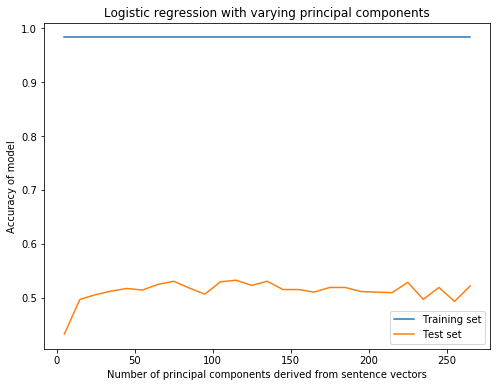

In [39]:
fig = plt.figure(figsize = (8, 6))
plt.plot(components, train_scores, label = 'Training set')
plt.plot(components, test_scores, label = 'Test set')
plt.xlabel('Number of principal components derived from sentence vectors')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Logistic regression with varying principal components')

In [40]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([components, train_scores, test_scores]).T), 
                      columns = ['components', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.53]
#May vary time to time

,components,train score,test score
7,75.0,0.983333,0.530259
11,115.0,0.983333,0.532181
13,135.0,0.983333,0.530259


In [41]:
#Add the score to the dict
all_scores['RF #1'] = 0.53

### Observations:

A random forest with no hyperparameter tuning gets highest testing set accuracy at 125 principal components.

How about if my engineered features are added back in?

## Random forest #2: more features

In [42]:
columns = ['char_count', 'token_count', 'mean_token_len', 'vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_andahalf[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Same thing but engineered features added in 
components = np.arange(5, 275, 20)
train_scores = []
test_scores = []

for n in components:
    X_train, X_test, y_train, y_test = prepare(sv_df,
                                               pca_components = n,
                                               normalize_vector = True, 
                                               features_to_norm = None, 
                                               other_features = ['char_count',
                                                                 'token_count',
                                                                'mean_token_len'])

    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preproc

Text(0.5, 1.0, 'Logistic regression with varying principal components')

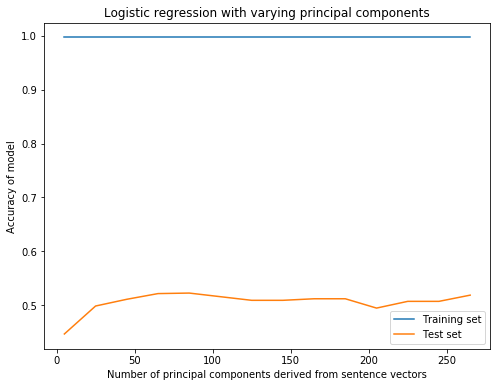

In [43]:
fig = plt.figure(figsize = (8, 6))
plt.plot(components, train_scores, label = 'Training set')
plt.plot(components, test_scores, label = 'Test set')
plt.xlabel('Number of principal components derived from sentence vectors')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Logistic regression with varying principal components')

In [44]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([components, train_scores, test_scores]).T), 
                      columns = ['components', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.53]
#May vary time to time

,components,train score,test score


In [45]:
#Add the score to the dict
all_scores['RF #2'] = 0.53

### Observations:

A random forest with 125 principal components and the engineered features gets 53% accuracy on the testing set. It may help to tune a few hyperparameters.

## Random forest #3: tuned estimators

In [46]:
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 125,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = ['char_count',
                                                             'token_count',
                                                            'mean_token_len'])

estimators = np.arange(5, 200, 20)
train_scores = []
test_scores = []

for n in estimators:
    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                 n_estimators = n,
                                 report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0.5, 1.0, 'Random forest')

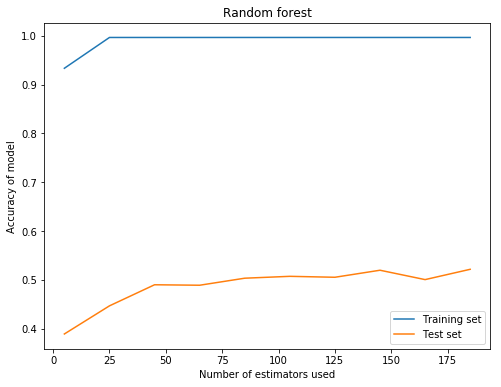

In [47]:
fig = plt.figure(figsize = (8, 6))
plt.plot(estimators, train_scores, label = 'Training set')
plt.plot(estimators, test_scores, label = 'Test set')
plt.xlabel('Number of estimators used')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Random forest')

In [48]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([estimators, train_scores, test_scores]).T), 
                      columns = ['estimators', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.51]
#May vary time to time

,estimators,train score,test score
7,145.0,0.996795,0.519693
9,185.0,0.996795,0.521614


In [49]:
#Add the score to the dict
all_scores['RF #3'] = 0.53

### Observations: 
85 looks like the best number of estimators to use. Let's try tuning the max depth of each tree.

## Random forest #4: tuned depth

In [50]:
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 125,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = ['char_count',
                                                             'token_count',
                                                            'mean_token_len'])

depths = np.arange(8, 30, 2)
train_scores = []
test_scores = []

for n in depths:
    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                 n_estimators = 85,
                                 max_depth = n,
                                 report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0.5, 1.0, 'Random forest')

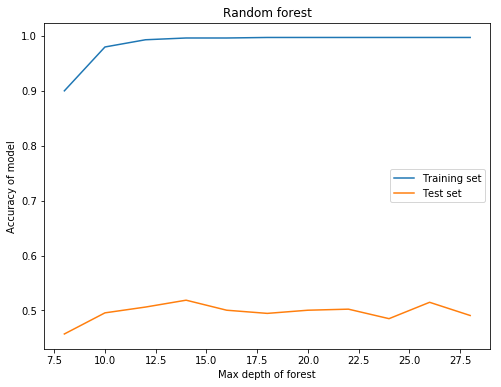

In [51]:
fig = plt.figure(figsize = (8, 6))
plt.plot(depths, train_scores, label = 'Training set')
plt.plot(depths, test_scores, label = 'Test set')
plt.xlabel('Max depth of forest')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Random forest')

In [52]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([depths, train_scores, test_scores]).T), 
                      columns = ['depth', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.51]

,depth,train score,test score
3,14.0,0.995833,0.518732
9,26.0,0.996795,0.514890


In [53]:
#Add the score to the dict
all_scores['RF #4'] = 0.52

### Observations:

Highest accuracy at depth of 16.

## Final random forest

In [54]:
#Final random forest model
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 125,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = ['char_count',
                                                             'token_count',
                                                            'mean_token_len'])

y_hat_train, y_hat_test, train_score, test_score = rf(
                            X_train, X_test, y_train, y_test,
                             n_estimators = 85,
                             max_depth = 16,
                             report = True)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Random forest, training set:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       664
           2       1.00      1.00      1.00       651
           3       1.00      1.00      1.00       686
           4       0.99      1.00      0.99       466
           5       1.00      0.99      0.99       653

   micro avg       1.00      1.00      1.00      3120
   macro avg       1.00      1.00      1.00      3120
weighted avg       1.00      1.00      1.00      3120

Random forest, testing set:
              precision    recall  f1-score   support

           1       0.49      0.53      0.51       236
           2       0.41      0.45      0.43       185
           3       0.58      0.60      0.59       236
           4       0.69      0.62      0.65       137
           5       0.46      0.39      0.42       247

   micro avg       0.51      0.51      0.51      1041
   macro avg       0.52      0.52      0.52      1041
weighted avg       0

In [55]:
#Add the score to the dict
all_scores['RF #5'] = test_score

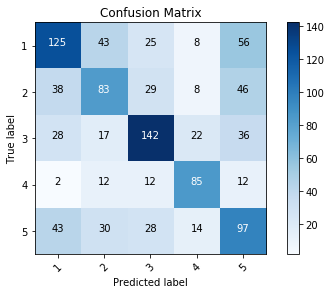

In [56]:
# CONFUSION MATRIX
classes = ['1', '2', '3', '4', '5']
#Create a confusion matrix with the training results
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix with the test results
conf_matrix_test = confusion_matrix(y_hat_test, y_test)
plot_conf_matrix(conf_matrix_test, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues)

### Observations:

With an ensemble classifier we can achieve 53% accuracy in predicting test data. This is better than random guessing (20%) but not impressive enough to implement. The models we've used so far have all been 'shallow': it's time to go deep.

<a id = 'nn'></a>

[(Back to top)](#top)

# Deep neural networks

## Neural network #1: dense

This is the most basic kind of neural network. It uses 'dense' layers to sort and parse the data and to arrive at a prediction for each sample. It does not use any special parameters for regularization. We can abandon the principal components and feed this network the full 300-scalar vector for each sentence in the text.

In [57]:
#Prepare data for modeling
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_andahalf[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Don't do PCA, just create columns for all vectors
X = StandardScaler().fit_transform(vec_to_col(sv_df['vector'].values))
y = pd.get_dummies(sv_df['label'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

#Split test set to create a validation set
X_val = X_test[600:]
X_test = X_test[:600]
y_val = y_test[600:]
y_test = y_test[:600]

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [58]:
#Neural network
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', 
                      # kernel_regularizer=regularizers.l2(0.005),
                       input_shape=(300,))) 
#model.add(layers.Dropout(0.3, input_shape=(125,)))
model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer = 'adam', #also try 'adam'
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 130       
Total params: 19,005
Trainable params: 19,005
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(X_train,
                    y_train,
                    epochs = 120,
                    validation_data = (X_val, y_val))

Train on 3120 samples, validate on 441 samples
Epoch 1/120
3120/3120 [==============================] - ETA: 1:20 - loss: 1.7592 - acc: 0.187 - ETA: 1s - loss: 1.5925 - acc: 0.2868  - ETA: 0s - loss: 1.5285 - acc: 0.333 - 1s 327us/step - loss: 1.4958 - acc: 0.3542 - val_loss: 1.4214 - val_acc: 0.4263
Epoch 2/120
3120/3120 [==============================] - ETA: 0s - loss: 1.2940 - acc: 0.625 - ETA: 0s - loss: 1.3197 - acc: 0.476 - ETA: 0s - loss: 1.2854 - acc: 0.483 - 0s 50us/step - loss: 1.2827 - acc: 0.4869 - val_loss: 1.3865 - val_acc: 0.4467
Epoch 3/120
3120/3120 [==============================] - ETA: 0s - loss: 0.8751 - acc: 0.843 - ETA: 0s - loss: 1.1433 - acc: 0.569 - ETA: 0s - loss: 1.1302 - acc: 0.570 - 0s 49us/step - loss: 1.1282 - acc: 0.5644 - val_loss: 1.3566 - val_acc: 0.4694
Epoch 4/120
3120/3120 [==============================] - ETA: 0s - loss: 1.0102 - acc: 0.562 - ETA: 0s - loss: 0.9575 - acc: 0.651 - ETA: 0s - loss: 0.9915 - acc: 0.620 - 0s 49us/step - loss: 0.9984

3120/3120 [==============================] - ETA: 0s - loss: 0.0401 - acc: 1.000 - ETA: 0s - loss: 0.0664 - acc: 0.976 - ETA: 0s - loss: 0.0752 - acc: 0.977 - 0s 50us/step - loss: 0.0858 - acc: 0.9763 - val_loss: 2.8541 - val_acc: 0.5147
Epoch 34/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0095 - acc: 1.000 - ETA: 0s - loss: 0.0758 - acc: 0.978 - ETA: 0s - loss: 0.0709 - acc: 0.979 - 0s 47us/step - loss: 0.0790 - acc: 0.9776 - val_loss: 2.8326 - val_acc: 0.5465
Epoch 35/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0146 - acc: 1.000 - ETA: 0s - loss: 0.0641 - acc: 0.983 - ETA: 0s - loss: 0.0796 - acc: 0.978 - 0s 47us/step - loss: 0.0831 - acc: 0.9763 - val_loss: 2.8815 - val_acc: 0.5351
Epoch 36/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0462 - acc: 1.000 - ETA: 0s - loss: 0.0992 - acc: 0.975 - ETA: 0s - loss: 0.0867 - acc: 0.974 - 0s 46us/step - loss: 0.0865 - acc: 0.9747 - val_loss: 2.9039 - val_acc: 0.5283
Epoch 37/

Epoch 66/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0046 - acc: 1.000 - ETA: 0s - loss: 0.0584 - acc: 0.980 - ETA: 0s - loss: 0.0633 - acc: 0.977 - 0s 49us/step - loss: 0.0631 - acc: 0.9769 - val_loss: 3.2156 - val_acc: 0.5283
Epoch 67/120
3120/3120 [==============================] - ETA: 0s - loss: 0.1670 - acc: 0.937 - ETA: 0s - loss: 0.0566 - acc: 0.976 - ETA: 0s - loss: 0.0570 - acc: 0.977 - 0s 49us/step - loss: 0.0655 - acc: 0.9750 - val_loss: 3.2240 - val_acc: 0.5170
Epoch 68/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0588 - acc: 0.968 - ETA: 0s - loss: 0.0802 - acc: 0.969 - ETA: 0s - loss: 0.1326 - acc: 0.953 - 0s 48us/step - loss: 0.1787 - acc: 0.9372 - val_loss: 3.4092 - val_acc: 0.4921
Epoch 69/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0273 - acc: 1.000 - ETA: 0s - loss: 0.2533 - acc: 0.915 - ETA: 0s - loss: 0.2744 - acc: 0.913 - 0s 46us/step - loss: 0.2709 - acc: 0.9093 - val_loss: 2.8766 - val_acc: 0.5

3120/3120 [==============================] - ETA: 0s - loss: 0.0079 - acc: 1.000 - ETA: 0s - loss: 0.1750 - acc: 0.948 - 0s 41us/step - loss: 0.1609 - acc: 0.9510 - val_loss: 3.2478 - val_acc: 0.5283
Epoch 100/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0774 - acc: 0.968 - ETA: 0s - loss: 0.0963 - acc: 0.973 - 0s 40us/step - loss: 0.0906 - acc: 0.9712 - val_loss: 3.3429 - val_acc: 0.5193
Epoch 101/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0796 - acc: 0.968 - ETA: 0s - loss: 0.0682 - acc: 0.976 - ETA: 0s - loss: 0.0648 - acc: 0.974 - 0s 46us/step - loss: 0.0667 - acc: 0.9753 - val_loss: 3.3013 - val_acc: 0.5510
Epoch 102/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0490 - acc: 1.000 - ETA: 0s - loss: 0.0597 - acc: 0.980 - ETA: 0s - loss: 0.0631 - acc: 0.980 - 0s 45us/step - loss: 0.0606 - acc: 0.9795 - val_loss: 3.4180 - val_acc: 0.5397
Epoch 103/120
3120/3120 [==============================] - ETA: 0s - loss: 0.0247 

In [61]:
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)

600/600 [==============================] - ETA:  - 0s 26us/step


In [62]:
print('Training results:')
results_train

Training results:


[0.03984359144949569, 0.9826923076923076]

In [63]:
print('Testing results:')
results_test

Testing results:


[3.840539061228434, 0.5166666666666667]

In [64]:
#Add score to score dict
all_scores['NN 1'] = 0.49

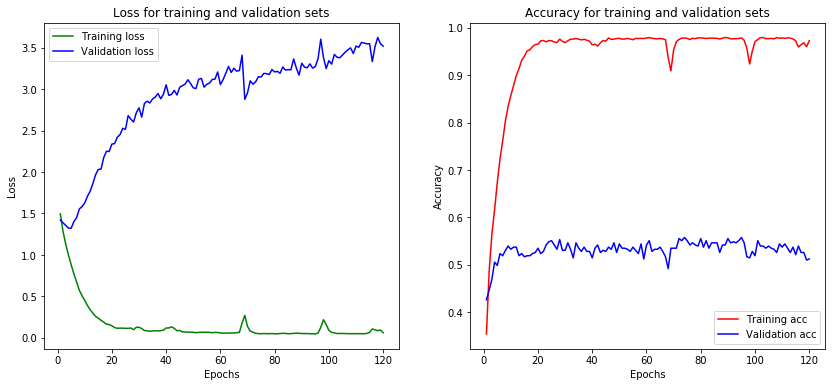

In [65]:
model_dict = model.history.history
plot_nn(model_dict)

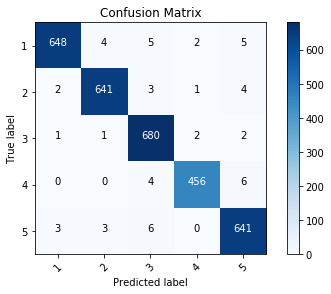

In [66]:
#Look at confusion matrix of results
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

classes = [str(i) for i in np.arange(1, 6, 1)]
cm = confusion_matrix(y_train.values.argmax(axis = 1), y_hat_train.argmax(axis = 1))
plot_conf_matrix(cm, classes )

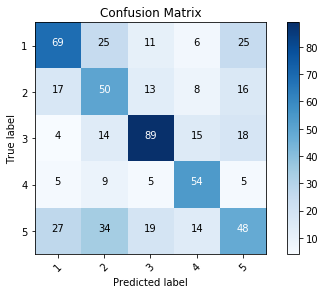

In [67]:
cm = confusion_matrix(y_test.values.argmax(axis = 1), y_hat_test.argmax(axis = 1))
plot_conf_matrix(cm, classes)

### Observations:
Intrigued to see that this model predicted chapter 3 the best. Overall results are underwhelming compared to random forests. Perhaps tuning some parameters will improve performance. The model may be overfitted to the training data, so we can try using regularization to prune it back to work with other data.

## Neural network #2: regularized

In [68]:
#Use same data as network #1

model = models.Sequential()
model.add(layers.Dense(50, activation='relu', 
                      kernel_regularizer=regularizers.l2(0.005),
                       input_shape=(300,))) 
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

In [69]:
history = model.fit(X_train,
                    y_train,
                    epochs = 120,
                    validation_data = (X_val, y_val))

Train on 3120 samples, validate on 441 samples
Epoch 1/120
3120/3120 [==============================] - ETA: 37s - loss: 2.2181 - acc: 0.15 - ETA: 1s - loss: 2.2159 - acc: 0.2101 - ETA: 0s - loss: 2.1485 - acc: 0.218 - ETA: 0s - loss: 2.1083 - acc: 0.228 - 1s 195us/step - loss: 2.0916 - acc: 0.2340 - val_loss: 1.9499 - val_acc: 0.3016
Epoch 2/120
3120/3120 [==============================] - ETA: 0s - loss: 1.9963 - acc: 0.281 - ETA: 0s - loss: 1.9705 - acc: 0.263 - ETA: 0s - loss: 1.9473 - acc: 0.283 - ETA: 0s - loss: 1.9238 - acc: 0.293 - 0s 66us/step - loss: 1.9124 - acc: 0.3022 - val_loss: 1.8572 - val_acc: 0.3605
Epoch 3/120
3120/3120 [==============================] - ETA: 0s - loss: 1.8287 - acc: 0.437 - ETA: 0s - loss: 1.8694 - acc: 0.307 - ETA: 0s - loss: 1.8450 - acc: 0.320 - ETA: 0s - loss: 1.8323 - acc: 0.324 - 0s 64us/step - loss: 1.8218 - acc: 0.3365 - val_loss: 1.7667 - val_acc: 0.3991
Epoch 4/120
3120/3120 [==============================] - ETA: 0s - loss: 1.7293 - acc: 

3120/3120 [==============================] - ETA: 0s - loss: 0.6342 - acc: 0.750 - ETA: 0s - loss: 0.9668 - acc: 0.717 - ETA: 0s - loss: 1.0068 - acc: 0.698 - ETA: 0s - loss: 1.0301 - acc: 0.679 - 0s 60us/step - loss: 1.0241 - acc: 0.6808 - val_loss: 1.3866 - val_acc: 0.5306
Epoch 30/120
3120/3120 [==============================] - ETA: 0s - loss: 0.8560 - acc: 0.656 - ETA: 0s - loss: 0.9520 - acc: 0.706 - ETA: 0s - loss: 1.0041 - acc: 0.690 - ETA: 0s - loss: 1.0230 - acc: 0.681 - 0s 56us/step - loss: 1.0251 - acc: 0.6814 - val_loss: 1.3748 - val_acc: 0.5420
Epoch 31/120
3120/3120 [==============================] - ETA: 0s - loss: 1.3355 - acc: 0.656 - ETA: 0s - loss: 1.0061 - acc: 0.685 - ETA: 0s - loss: 1.0115 - acc: 0.680 - ETA: 0s - loss: 1.0432 - acc: 0.669 - 0s 58us/step - loss: 1.0431 - acc: 0.6702 - val_loss: 1.3581 - val_acc: 0.5556
Epoch 32/120
3120/3120 [==============================] - ETA: 0s - loss: 1.1612 - acc: 0.656 - ETA: 0s - loss: 1.0026 - acc: 0.699 - ETA: 0s - lo

3120/3120 [==============================] - ETA: 0s - loss: 0.7734 - acc: 0.781 - ETA: 0s - loss: 0.7786 - acc: 0.796 - ETA: 0s - loss: 0.8002 - acc: 0.789 - 0s 50us/step - loss: 0.8113 - acc: 0.7856 - val_loss: 1.5485 - val_acc: 0.5873
Epoch 60/120
3120/3120 [==============================] - ETA: 1s - loss: 0.8330 - acc: 0.781 - ETA: 0s - loss: 0.7667 - acc: 0.795 - ETA: 0s - loss: 0.7857 - acc: 0.789 - 0s 58us/step - loss: 0.7932 - acc: 0.7846 - val_loss: 1.5702 - val_acc: 0.5941
Epoch 61/120
3120/3120 [==============================] - ETA: 0s - loss: 0.7177 - acc: 0.781 - ETA: 0s - loss: 0.7181 - acc: 0.815 - ETA: 0s - loss: 0.7245 - acc: 0.810 - ETA: 0s - loss: 0.7663 - acc: 0.795 - 0s 56us/step - loss: 0.7670 - acc: 0.7952 - val_loss: 1.6269 - val_acc: 0.5624
Epoch 62/120
3120/3120 [==============================] - ETA: 0s - loss: 0.6607 - acc: 0.843 - ETA: 0s - loss: 0.7804 - acc: 0.786 - ETA: 0s - loss: 0.7939 - acc: 0.784 - ETA: 0s - loss: 0.8017 - acc: 0.779 - 0s 56us/step

3120/3120 [==============================] - ETA: 0s - loss: 0.6957 - acc: 0.781 - ETA: 0s - loss: 0.6651 - acc: 0.848 - ETA: 0s - loss: 0.7174 - acc: 0.824 - ETA: 0s - loss: 0.7219 - acc: 0.821 - 0s 56us/step - loss: 0.7207 - acc: 0.8221 - val_loss: 1.6559 - val_acc: 0.6009
Epoch 90/120
3120/3120 [==============================] - ETA: 0s - loss: 0.5588 - acc: 0.906 - ETA: 0s - loss: 0.6605 - acc: 0.832 - ETA: 0s - loss: 0.6865 - acc: 0.823 - 0s 50us/step - loss: 0.6931 - acc: 0.8221 - val_loss: 1.6035 - val_acc: 0.5782
Epoch 91/120
3120/3120 [==============================] - ETA: 0s - loss: 0.6771 - acc: 0.812 - ETA: 0s - loss: 0.7220 - acc: 0.820 - ETA: 0s - loss: 0.7348 - acc: 0.812 - 0s 50us/step - loss: 0.7268 - acc: 0.8157 - val_loss: 1.6033 - val_acc: 0.5896
Epoch 92/120
3120/3120 [==============================] - ETA: 0s - loss: 0.8660 - acc: 0.750 - ETA: 0s - loss: 0.6984 - acc: 0.828 - ETA: 0s - loss: 0.7373 - acc: 0.818 - 0s 56us/step - loss: 0.7579 - acc: 0.8106 - val_lo

3120/3120 [==============================] - ETA: 0s - loss: 0.6365 - acc: 0.843 - ETA: 0s - loss: 0.6565 - acc: 0.847 - ETA: 0s - loss: 0.6627 - acc: 0.845 - 0s 52us/step - loss: 0.6746 - acc: 0.8362 - val_loss: 1.6850 - val_acc: 0.5850


In [70]:
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)

600/600 [==============================] - ETA:  - 0s 26us/step


In [71]:
print('Training results:')
results_train

Training results:


[0.3737882070052318, 0.9538461538461539]

In [72]:
print('Testing results:')
results_test

Testing results:


[1.9033907906214396, 0.536666667064031]

In [73]:
#Add score to dict
all_scores['NN 2'] = 0.53

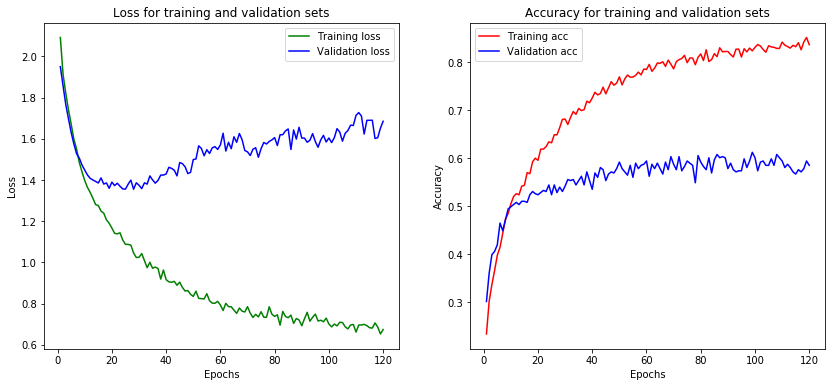

In [74]:
model_dict = model.history.history
plot_nn(model_dict)

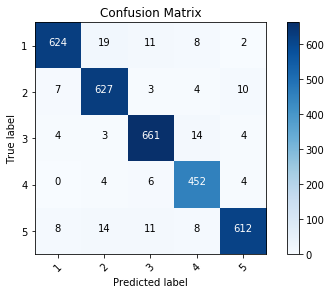

In [75]:
#Look at confusion matrix of results
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

classes = [str(i) for i in np.arange(1, 6, 1)]
cm = confusion_matrix(y_train.values.argmax(axis = 1), y_hat_train.argmax(axis = 1))
plot_conf_matrix(cm, classes )

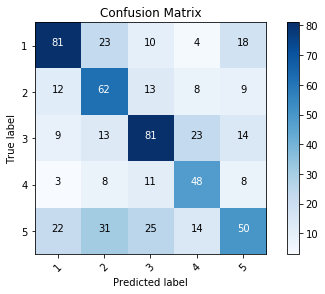

In [76]:
cm = confusion_matrix(y_test.values.argmax(axis = 1), y_hat_test.argmax(axis = 1))
plot_conf_matrix(cm, classes)

### Obversations:

Even with regularization, this network shows only slight improvement over the first. Use of L2 and drop out layers has increased accuracy to only 53%. A more advanced model might perform better.


## Neural network #3: GRU

Adding a GRU layer may help the model's 'short-term memory' as it peruses the samples. The GRU layer will only work properly if we use an embedding layer first. The embedding layer won't work with the 'mean sentence vectors' that we've been using so far, so we'll have to preprocess the datda in a way. We'll use Keras's NLP preprocessing tools to turn sentences from the text into new embedding vectors. These vectors will only place the sentences in the 'space' of the text itself, not within the 'space' of a larger corpus, as with Word2Vec.

In [77]:
#New data:
#Down-sample chapters 1 and 5, up-sample chapter 4
sv1_sample = sv_df1.sample(900, replace = False)
sents1 = sv1_sample['sentence'].values
ys_1 = sv1_sample['label'].values

sents2 = sv_df2['sentence'].values
ys_2 = sv_df2['label'].values

sents3 = sv_df3['sentence'].values
ys_3 = sv_df3['label'].values

sv4_sample = sv_df4.sample(200, replace = False)
sv4_andahalf = sv_df4.append([sv4_sample], ignore_index = True)
sents4 = sv4_andahalf['sentence'].values
ys_4 = sv4_andahalf['label'].values

sv5_sample = sv_df5.sample(900, replace = False)
sents5 = sv5_sample['sentence'].values
ys_5 = sv5_sample['label'].values

#Add all arrays of sentences together to be fed into tokenizer
sents = np.concatenate((sents1, sents2, sents3, sents4, sents5))

#Add all arrays of ys together
ys = np.concatenate((ys_1, ys_2, ys_3, ys_4, ys_5))

In [78]:
tokenizer = text.Tokenizer(num_words=8000)
tokenizer.fit_on_texts(list(sents))
list_tokenized_train = tokenizer.texts_to_sequences(sents)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=50)
y = pd.get_dummies(ys)
X_train, X_test, y_train, y_test = train_test_split(X_t, y, random_state=12)

In [79]:
#Neural network with embedding layer using tokenized sentences, not Word2Vec
model = models.Sequential()
model.add(layers.Embedding(8000, 128,))
model.add(GRU(50, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1024000   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          26850     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 255       
Total para

In [81]:
#Note: when run with more epochs (e.g. 100, 1000) results stayed the same
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    validation_split = 0.1)

Train on 2808 samples, validate on 312 samples
Epoch 1/50
2808/2808 [==============================] - ETA: 1:20 - loss: 1.6169 - acc: 0.125 - ETA: 28s - loss: 1.6165 - acc: 0.166 - ETA: 18s - loss: 1.6120 - acc: 0.16 - ETA: 13s - loss: 1.6109 - acc: 0.18 - ETA: 11s - loss: 1.6094 - acc: 0.18 - ETA: 9s - loss: 1.6091 - acc: 0.1875 - ETA: 8s - loss: 1.6087 - acc: 0.192 - ETA: 8s - loss: 1.6091 - acc: 0.192 - ETA: 7s - loss: 1.6097 - acc: 0.183 - ETA: 7s - loss: 1.6087 - acc: 0.189 - ETA: 6s - loss: 1.6081 - acc: 0.194 - ETA: 6s - loss: 1.6086 - acc: 0.194 - ETA: 6s - loss: 1.6089 - acc: 0.195 - ETA: 5s - loss: 1.6090 - acc: 0.196 - ETA: 5s - loss: 1.6089 - acc: 0.196 - ETA: 5s - loss: 1.6097 - acc: 0.197 - ETA: 5s - loss: 1.6094 - acc: 0.197 - ETA: 4s - loss: 1.6085 - acc: 0.201 - ETA: 4s - loss: 1.6084 - acc: 0.203 - ETA: 4s - loss: 1.6080 - acc: 0.203 - ETA: 4s - loss: 1.6081 - acc: 0.201 - ETA: 3s - loss: 1.6075 - acc: 0.202 - ETA: 3s - loss: 1.6071 - acc: 0.206 - ETA: 3s - loss: 1.6

2808/2808 [==============================] - ETA: 4s - loss: 1.1093 - acc: 0.625 - ETA: 4s - loss: 1.1743 - acc: 0.546 - ETA: 4s - loss: 1.1808 - acc: 0.552 - ETA: 4s - loss: 1.1670 - acc: 0.578 - ETA: 4s - loss: 1.1660 - acc: 0.593 - ETA: 4s - loss: 1.1743 - acc: 0.580 - ETA: 4s - loss: 1.1868 - acc: 0.570 - ETA: 4s - loss: 1.1735 - acc: 0.576 - ETA: 3s - loss: 1.1738 - acc: 0.579 - ETA: 3s - loss: 1.1735 - acc: 0.564 - ETA: 3s - loss: 1.1588 - acc: 0.566 - ETA: 3s - loss: 1.1569 - acc: 0.570 - ETA: 3s - loss: 1.1599 - acc: 0.557 - ETA: 3s - loss: 1.1556 - acc: 0.554 - ETA: 3s - loss: 1.1557 - acc: 0.556 - ETA: 3s - loss: 1.1527 - acc: 0.556 - ETA: 2s - loss: 1.1521 - acc: 0.551 - ETA: 2s - loss: 1.1565 - acc: 0.550 - ETA: 2s - loss: 1.1482 - acc: 0.554 - ETA: 2s - loss: 1.1462 - acc: 0.558 - ETA: 2s - loss: 1.1497 - acc: 0.557 - ETA: 2s - loss: 1.1421 - acc: 0.561 - ETA: 2s - loss: 1.1378 - acc: 0.565 - ETA: 2s - loss: 1.1300 - acc: 0.562 - ETA: 2s - loss: 1.1298 - acc: 0.561 - ETA: 

2808/2808 [==============================] - ETA: 5s - loss: 0.3914 - acc: 0.875 - ETA: 4s - loss: 0.3377 - acc: 0.875 - ETA: 3s - loss: 0.4604 - acc: 0.843 - ETA: 3s - loss: 0.4248 - acc: 0.852 - ETA: 3s - loss: 0.3815 - acc: 0.878 - ETA: 3s - loss: 0.3795 - acc: 0.880 - ETA: 3s - loss: 0.3636 - acc: 0.888 - ETA: 3s - loss: 0.3566 - acc: 0.891 - ETA: 3s - loss: 0.3569 - acc: 0.890 - ETA: 3s - loss: 0.3489 - acc: 0.895 - ETA: 3s - loss: 0.3724 - acc: 0.882 - ETA: 3s - loss: 0.3665 - acc: 0.883 - ETA: 3s - loss: 0.3592 - acc: 0.885 - ETA: 3s - loss: 0.3611 - acc: 0.885 - ETA: 3s - loss: 0.3676 - acc: 0.881 - ETA: 2s - loss: 0.3645 - acc: 0.881 - ETA: 2s - loss: 0.3610 - acc: 0.882 - ETA: 2s - loss: 0.3653 - acc: 0.884 - ETA: 2s - loss: 0.3630 - acc: 0.885 - ETA: 2s - loss: 0.3714 - acc: 0.882 - ETA: 2s - loss: 0.3686 - acc: 0.884 - ETA: 2s - loss: 0.3688 - acc: 0.884 - ETA: 2s - loss: 0.3685 - acc: 0.883 - ETA: 2s - loss: 0.3652 - acc: 0.885 - ETA: 2s - loss: 0.3675 - acc: 0.881 - ETA: 

2808/2808 [==============================] - ETA: 4s - loss: 0.1131 - acc: 0.937 - ETA: 3s - loss: 0.1695 - acc: 0.937 - ETA: 3s - loss: 0.1983 - acc: 0.925 - ETA: 3s - loss: 0.2073 - acc: 0.932 - ETA: 3s - loss: 0.2026 - acc: 0.933 - ETA: 3s - loss: 0.2130 - acc: 0.928 - ETA: 3s - loss: 0.2032 - acc: 0.932 - ETA: 3s - loss: 0.2058 - acc: 0.930 - ETA: 3s - loss: 0.2112 - acc: 0.929 - ETA: 3s - loss: 0.2103 - acc: 0.932 - ETA: 3s - loss: 0.2036 - acc: 0.935 - ETA: 3s - loss: 0.1952 - acc: 0.939 - ETA: 2s - loss: 0.2017 - acc: 0.939 - ETA: 2s - loss: 0.1966 - acc: 0.940 - ETA: 2s - loss: 0.1930 - acc: 0.942 - ETA: 2s - loss: 0.1864 - acc: 0.945 - ETA: 2s - loss: 0.1820 - acc: 0.946 - ETA: 2s - loss: 0.1764 - acc: 0.949 - ETA: 2s - loss: 0.1843 - acc: 0.946 - ETA: 2s - loss: 0.1877 - acc: 0.946 - ETA: 2s - loss: 0.1856 - acc: 0.944 - ETA: 2s - loss: 0.1856 - acc: 0.944 - ETA: 2s - loss: 0.1861 - acc: 0.944 - ETA: 2s - loss: 0.1891 - acc: 0.943 - ETA: 2s - loss: 0.1964 - acc: 0.942 - ETA: 

2808/2808 [==============================] - ETA: 3s - loss: 0.0449 - acc: 0.968 - ETA: 3s - loss: 0.1036 - acc: 0.947 - ETA: 3s - loss: 0.0838 - acc: 0.962 - ETA: 3s - loss: 0.1239 - acc: 0.950 - ETA: 3s - loss: 0.1253 - acc: 0.951 - ETA: 2s - loss: 0.1151 - acc: 0.957 - ETA: 2s - loss: 0.1174 - acc: 0.956 - ETA: 2s - loss: 0.1133 - acc: 0.960 - ETA: 2s - loss: 0.1116 - acc: 0.961 - ETA: 2s - loss: 0.1115 - acc: 0.962 - ETA: 2s - loss: 0.1051 - acc: 0.965 - ETA: 2s - loss: 0.1010 - acc: 0.968 - ETA: 2s - loss: 0.1032 - acc: 0.968 - ETA: 2s - loss: 0.1050 - acc: 0.967 - ETA: 2s - loss: 0.1067 - acc: 0.965 - ETA: 2s - loss: 0.1096 - acc: 0.964 - ETA: 2s - loss: 0.1132 - acc: 0.963 - ETA: 2s - loss: 0.1101 - acc: 0.964 - ETA: 1s - loss: 0.1138 - acc: 0.962 - ETA: 1s - loss: 0.1117 - acc: 0.963 - ETA: 1s - loss: 0.1090 - acc: 0.964 - ETA: 1s - loss: 0.1076 - acc: 0.965 - ETA: 1s - loss: 0.1079 - acc: 0.965 - ETA: 1s - loss: 0.1085 - acc: 0.964 - ETA: 1s - loss: 0.1097 - acc: 0.964 - ETA: 

2808/2808 [==============================] - ETA: 4s - loss: 0.0562 - acc: 1.000 - ETA: 3s - loss: 0.1025 - acc: 0.968 - ETA: 3s - loss: 0.1251 - acc: 0.956 - ETA: 3s - loss: 0.1029 - acc: 0.964 - ETA: 3s - loss: 0.1234 - acc: 0.951 - ETA: 3s - loss: 0.1126 - acc: 0.960 - ETA: 3s - loss: 0.1096 - acc: 0.960 - ETA: 2s - loss: 0.1067 - acc: 0.962 - ETA: 3s - loss: 0.1065 - acc: 0.962 - ETA: 2s - loss: 0.0997 - acc: 0.966 - ETA: 2s - loss: 0.0988 - acc: 0.968 - ETA: 2s - loss: 0.0995 - acc: 0.970 - ETA: 2s - loss: 0.0956 - acc: 0.971 - ETA: 2s - loss: 0.0939 - acc: 0.971 - ETA: 2s - loss: 0.0920 - acc: 0.971 - ETA: 2s - loss: 0.0871 - acc: 0.973 - ETA: 2s - loss: 0.0878 - acc: 0.974 - ETA: 2s - loss: 0.0886 - acc: 0.974 - ETA: 2s - loss: 0.0908 - acc: 0.973 - ETA: 2s - loss: 0.0916 - acc: 0.974 - ETA: 2s - loss: 0.0913 - acc: 0.973 - ETA: 1s - loss: 0.0897 - acc: 0.972 - ETA: 1s - loss: 0.0902 - acc: 0.973 - ETA: 1s - loss: 0.0915 - acc: 0.971 - ETA: 1s - loss: 0.0919 - acc: 0.971 - ETA: 

2808/2808 [==============================] - ETA: 2s - loss: 0.0528 - acc: 0.968 - ETA: 3s - loss: 0.0569 - acc: 0.989 - ETA: 3s - loss: 0.0985 - acc: 0.981 - ETA: 3s - loss: 0.0969 - acc: 0.977 - ETA: 3s - loss: 0.1100 - acc: 0.975 - ETA: 3s - loss: 0.1068 - acc: 0.974 - ETA: 3s - loss: 0.1112 - acc: 0.971 - ETA: 2s - loss: 0.1092 - acc: 0.970 - ETA: 2s - loss: 0.1308 - acc: 0.966 - ETA: 2s - loss: 0.1393 - acc: 0.960 - ETA: 2s - loss: 0.1576 - acc: 0.957 - ETA: 2s - loss: 0.1502 - acc: 0.960 - ETA: 2s - loss: 0.1446 - acc: 0.962 - ETA: 2s - loss: 0.1418 - acc: 0.961 - ETA: 2s - loss: 0.1401 - acc: 0.961 - ETA: 2s - loss: 0.1358 - acc: 0.963 - ETA: 2s - loss: 0.1368 - acc: 0.963 - ETA: 2s - loss: 0.1327 - acc: 0.963 - ETA: 2s - loss: 0.1296 - acc: 0.964 - ETA: 2s - loss: 0.1307 - acc: 0.962 - ETA: 2s - loss: 0.1396 - acc: 0.960 - ETA: 1s - loss: 0.1480 - acc: 0.958 - ETA: 1s - loss: 0.1473 - acc: 0.958 - ETA: 1s - loss: 0.1452 - acc: 0.958 - ETA: 1s - loss: 0.1507 - acc: 0.956 - ETA: 

2808/2808 [==============================] - ETA: 3s - loss: 0.0878 - acc: 0.968 - ETA: 3s - loss: 0.0782 - acc: 0.968 - ETA: 3s - loss: 0.0670 - acc: 0.962 - ETA: 3s - loss: 0.0675 - acc: 0.964 - ETA: 2s - loss: 0.0874 - acc: 0.961 - ETA: 2s - loss: 0.0895 - acc: 0.960 - ETA: 2s - loss: 0.1012 - acc: 0.954 - ETA: 2s - loss: 0.1010 - acc: 0.956 - ETA: 2s - loss: 0.0986 - acc: 0.957 - ETA: 2s - loss: 0.0933 - acc: 0.960 - ETA: 2s - loss: 0.1033 - acc: 0.962 - ETA: 2s - loss: 0.0992 - acc: 0.963 - ETA: 2s - loss: 0.0935 - acc: 0.966 - ETA: 2s - loss: 0.0921 - acc: 0.966 - ETA: 2s - loss: 0.0914 - acc: 0.967 - ETA: 2s - loss: 0.0951 - acc: 0.967 - ETA: 2s - loss: 0.1011 - acc: 0.965 - ETA: 2s - loss: 0.1032 - acc: 0.964 - ETA: 2s - loss: 0.1005 - acc: 0.965 - ETA: 2s - loss: 0.0994 - acc: 0.964 - ETA: 1s - loss: 0.1054 - acc: 0.963 - ETA: 1s - loss: 0.1032 - acc: 0.963 - ETA: 1s - loss: 0.1023 - acc: 0.963 - ETA: 1s - loss: 0.0992 - acc: 0.965 - ETA: 1s - loss: 0.0969 - acc: 0.965 - ETA: 

2808/2808 [==============================] - ETA: 4s - loss: 0.2042 - acc: 0.968 - ETA: 3s - loss: 0.1543 - acc: 0.979 - ETA: 3s - loss: 0.1150 - acc: 0.981 - ETA: 3s - loss: 0.0898 - acc: 0.986 - ETA: 3s - loss: 0.0883 - acc: 0.982 - ETA: 3s - loss: 0.0936 - acc: 0.980 - ETA: 2s - loss: 0.0932 - acc: 0.978 - ETA: 2s - loss: 0.0885 - acc: 0.979 - ETA: 2s - loss: 0.0857 - acc: 0.979 - ETA: 2s - loss: 0.0925 - acc: 0.980 - ETA: 2s - loss: 0.0870 - acc: 0.982 - ETA: 2s - loss: 0.0842 - acc: 0.982 - ETA: 2s - loss: 0.0860 - acc: 0.981 - ETA: 2s - loss: 0.0836 - acc: 0.981 - ETA: 2s - loss: 0.0909 - acc: 0.978 - ETA: 2s - loss: 0.0978 - acc: 0.975 - ETA: 2s - loss: 0.0939 - acc: 0.976 - ETA: 2s - loss: 0.0941 - acc: 0.975 - ETA: 1s - loss: 0.0956 - acc: 0.973 - ETA: 1s - loss: 0.0951 - acc: 0.973 - ETA: 1s - loss: 0.0915 - acc: 0.974 - ETA: 1s - loss: 0.0912 - acc: 0.974 - ETA: 1s - loss: 0.0883 - acc: 0.975 - ETA: 1s - loss: 0.0922 - acc: 0.974 - ETA: 1s - loss: 0.0898 - acc: 0.975 - ETA: 

2808/2808 [==============================] - ETA: 4s - loss: 0.1278 - acc: 0.968 - ETA: 3s - loss: 0.0683 - acc: 0.979 - ETA: 3s - loss: 0.0551 - acc: 0.987 - ETA: 3s - loss: 0.0557 - acc: 0.986 - ETA: 3s - loss: 0.0569 - acc: 0.988 - ETA: 3s - loss: 0.0570 - acc: 0.987 - ETA: 3s - loss: 0.0607 - acc: 0.987 - ETA: 3s - loss: 0.0715 - acc: 0.982 - ETA: 3s - loss: 0.0676 - acc: 0.984 - ETA: 2s - loss: 0.0660 - acc: 0.986 - ETA: 2s - loss: 0.0614 - acc: 0.987 - ETA: 2s - loss: 0.0657 - acc: 0.981 - ETA: 2s - loss: 0.0694 - acc: 0.979 - ETA: 2s - loss: 0.0769 - acc: 0.977 - ETA: 2s - loss: 0.0735 - acc: 0.978 - ETA: 2s - loss: 0.0743 - acc: 0.977 - ETA: 2s - loss: 0.0818 - acc: 0.973 - ETA: 2s - loss: 0.0805 - acc: 0.973 - ETA: 2s - loss: 0.1126 - acc: 0.969 - ETA: 2s - loss: 0.1323 - acc: 0.964 - ETA: 2s - loss: 0.1759 - acc: 0.959 - ETA: 1s - loss: 0.1782 - acc: 0.959 - ETA: 1s - loss: 0.1847 - acc: 0.959 - ETA: 1s - loss: 0.1829 - acc: 0.959 - ETA: 1s - loss: 0.1836 - acc: 0.957 - ETA: 

2808/2808 [==============================] - ETA: 2s - loss: 0.1063 - acc: 0.968 - ETA: 3s - loss: 0.0691 - acc: 0.968 - ETA: 3s - loss: 0.0487 - acc: 0.981 - ETA: 3s - loss: 0.0641 - acc: 0.977 - ETA: 3s - loss: 0.1005 - acc: 0.968 - ETA: 2s - loss: 0.1409 - acc: 0.968 - ETA: 2s - loss: 0.1218 - acc: 0.973 - ETA: 2s - loss: 0.1103 - acc: 0.975 - ETA: 2s - loss: 0.1065 - acc: 0.976 - ETA: 2s - loss: 0.1178 - acc: 0.973 - ETA: 2s - loss: 0.1144 - acc: 0.974 - ETA: 2s - loss: 0.1097 - acc: 0.975 - ETA: 2s - loss: 0.1048 - acc: 0.976 - ETA: 2s - loss: 0.1042 - acc: 0.976 - ETA: 2s - loss: 0.1012 - acc: 0.977 - ETA: 2s - loss: 0.0995 - acc: 0.976 - ETA: 2s - loss: 0.0968 - acc: 0.976 - ETA: 2s - loss: 0.0967 - acc: 0.975 - ETA: 1s - loss: 0.0953 - acc: 0.976 - ETA: 1s - loss: 0.0945 - acc: 0.976 - ETA: 1s - loss: 0.0904 - acc: 0.977 - ETA: 1s - loss: 0.0930 - acc: 0.976 - ETA: 1s - loss: 0.0926 - acc: 0.975 - ETA: 1s - loss: 0.0906 - acc: 0.976 - ETA: 1s - loss: 0.0913 - acc: 0.977 - ETA: 

2808/2808 [==============================] - ETA: 4s - loss: 0.0857 - acc: 0.968 - ETA: 3s - loss: 0.0331 - acc: 0.989 - ETA: 3s - loss: 0.0549 - acc: 0.975 - ETA: 3s - loss: 0.0461 - acc: 0.982 - ETA: 3s - loss: 0.0708 - acc: 0.979 - ETA: 3s - loss: 0.0651 - acc: 0.980 - ETA: 3s - loss: 0.0595 - acc: 0.983 - ETA: 3s - loss: 0.0562 - acc: 0.985 - ETA: 2s - loss: 0.0503 - acc: 0.987 - ETA: 2s - loss: 0.0530 - acc: 0.985 - ETA: 2s - loss: 0.0596 - acc: 0.983 - ETA: 2s - loss: 0.0597 - acc: 0.983 - ETA: 2s - loss: 0.0585 - acc: 0.983 - ETA: 2s - loss: 0.0560 - acc: 0.984 - ETA: 2s - loss: 0.0549 - acc: 0.985 - ETA: 2s - loss: 0.0556 - acc: 0.985 - ETA: 2s - loss: 0.0547 - acc: 0.984 - ETA: 2s - loss: 0.0524 - acc: 0.985 - ETA: 2s - loss: 0.0524 - acc: 0.985 - ETA: 2s - loss: 0.0531 - acc: 0.985 - ETA: 1s - loss: 0.0532 - acc: 0.985 - ETA: 1s - loss: 0.0538 - acc: 0.984 - ETA: 1s - loss: 0.0522 - acc: 0.985 - ETA: 1s - loss: 0.0506 - acc: 0.985 - ETA: 1s - loss: 0.0510 - acc: 0.986 - ETA: 

2808/2808 [==============================] - ETA: 3s - loss: 0.0391 - acc: 1.000 - ETA: 3s - loss: 0.0323 - acc: 0.989 - ETA: 3s - loss: 0.0233 - acc: 0.993 - ETA: 3s - loss: 0.0382 - acc: 0.991 - ETA: 3s - loss: 0.0376 - acc: 0.989 - ETA: 3s - loss: 0.0318 - acc: 0.991 - ETA: 2s - loss: 0.0273 - acc: 0.992 - ETA: 2s - loss: 0.0300 - acc: 0.991 - ETA: 2s - loss: 0.0464 - acc: 0.988 - ETA: 2s - loss: 0.0455 - acc: 0.989 - ETA: 2s - loss: 0.0479 - acc: 0.987 - ETA: 2s - loss: 0.0493 - acc: 0.985 - ETA: 2s - loss: 0.0470 - acc: 0.987 - ETA: 2s - loss: 0.0485 - acc: 0.986 - ETA: 2s - loss: 0.0478 - acc: 0.986 - ETA: 2s - loss: 0.0456 - acc: 0.987 - ETA: 2s - loss: 0.0441 - acc: 0.988 - ETA: 2s - loss: 0.0431 - acc: 0.988 - ETA: 2s - loss: 0.0415 - acc: 0.988 - ETA: 1s - loss: 0.0430 - acc: 0.986 - ETA: 1s - loss: 0.0443 - acc: 0.985 - ETA: 1s - loss: 0.0433 - acc: 0.986 - ETA: 1s - loss: 0.0424 - acc: 0.986 - ETA: 1s - loss: 0.0461 - acc: 0.985 - ETA: 1s - loss: 0.0463 - acc: 0.985 - ETA: 

2808/2808 [==============================] - ETA: 2s - loss: 0.0025 - acc: 1.000 - ETA: 3s - loss: 0.0391 - acc: 0.989 - ETA: 3s - loss: 0.0413 - acc: 0.987 - ETA: 3s - loss: 0.0307 - acc: 0.991 - ETA: 3s - loss: 0.0258 - acc: 0.993 - ETA: 2s - loss: 0.0419 - acc: 0.985 - ETA: 2s - loss: 0.0483 - acc: 0.985 - ETA: 2s - loss: 0.0476 - acc: 0.985 - ETA: 2s - loss: 0.0447 - acc: 0.986 - ETA: 2s - loss: 0.0599 - acc: 0.980 - ETA: 2s - loss: 0.0593 - acc: 0.979 - ETA: 2s - loss: 0.0550 - acc: 0.981 - ETA: 2s - loss: 0.0577 - acc: 0.980 - ETA: 2s - loss: 0.0569 - acc: 0.980 - ETA: 2s - loss: 0.0558 - acc: 0.981 - ETA: 2s - loss: 0.0559 - acc: 0.981 - ETA: 2s - loss: 0.0542 - acc: 0.981 - ETA: 2s - loss: 0.0521 - acc: 0.982 - ETA: 2s - loss: 0.0499 - acc: 0.982 - ETA: 1s - loss: 0.0525 - acc: 0.981 - ETA: 1s - loss: 0.0502 - acc: 0.982 - ETA: 1s - loss: 0.0516 - acc: 0.982 - ETA: 1s - loss: 0.0514 - acc: 0.981 - ETA: 1s - loss: 0.0500 - acc: 0.982 - ETA: 1s - loss: 0.0502 - acc: 0.982 - ETA: 

In [82]:
results_train = model.evaluate(X_train, y_train)

3120/3120 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 221us/step


In [83]:
print('Training results:', results_train)

Training results: [0.3899818426708092, 0.9493589743589743]


In [84]:
results_test = model.evaluate(X_test, y_test)

1041/1041 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 219us/step


In [85]:
print('Testing results:', results_test)

Testing results: [4.10703074050339, 0.5773294912749591]


In [86]:
#Add score to dict
all_scores['NN 3'] = 0.55

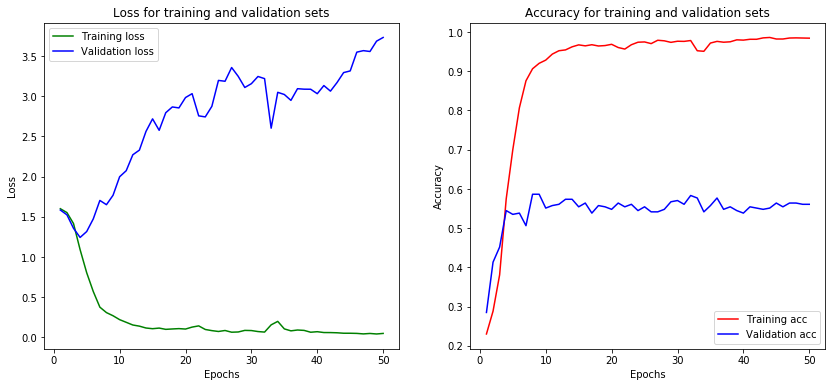

In [87]:
model_dict = model.history.history
plot_nn(model_dict)

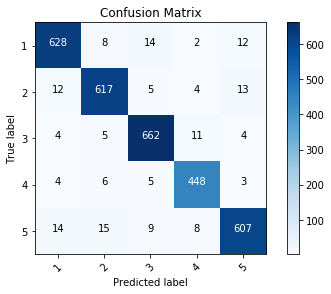

In [88]:
#Look at confusion matrix of results
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

classes = [str(i) for i in np.arange(1, 6, 1)]
cm = confusion_matrix(y_train.values.argmax(axis = 1), y_hat_train.argmax(axis = 1))
plot_conf_matrix(cm, classes )

#cm = confusion_matrix(y_test.values.argmax(axis = 1), y_hat_test.argmax(axis = 1))
#plot_conf_matrix(cm, classes)

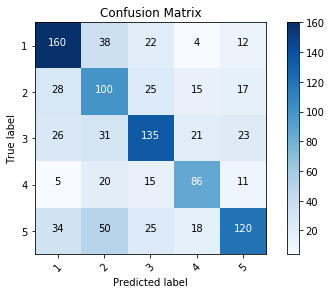

In [89]:
cm = confusion_matrix(y_test.values.argmax(axis = 1), y_hat_test.argmax(axis = 1))
plot_conf_matrix(cm, classes)

### Observations:

The visuals we explored earlier in which blobs of meaning were identified no longer apply. The model does not perform any better than the others which used the 'mean sentence vectors,' and some interpretability has been lost since our earlier exploration of the principal components in three dimensions no longer applies>

## Final observations:

A model with GRU and its own embeddings performs very slightly better than the other neural networks, but not enough in my opinion to justify the loss of interpretability.

<a id = 'conclusions'></a>

# Conclusions

So, can a deep neural network appreciate a piece of literature? Our highest-performing neural network achieved 55% accuracy. It would have gotten 20% with random guessing. That's not bad, and it suggests that the words of the text still have some coherence after being turned into numbers. But it is underwhelming for a much-hyped machine learning algorithm when we compare it to a lower-tech random forest which it did not outperform. The neural network needed a less interpretable version of the data to run well, and this counts against it, too, at least for me. I wanted to learn more about the connections between the words I read and the numbers the computer sees. Perhaps a similar model would perform better on a longer text? 

Part of the beauty of the book lies in its short length, but its pithy elegance is not helpful for model training. *Ulysses* is much longer and is famously unreadable. Maybe the computer could outperform a human in its comprehension of that book?

In [90]:
#Look at all scores
all_scores

{'LR #1': 0.33,
 'LR #2': 0.22,
 'LR #3': 0.45,
 'LR #4': 0.46,
 'RF #1': 0.53,
 'RF #2': 0.53,
 'RF #3': 0.53,
 'RF #4': 0.52,
 'RF #5': 0.5110470701248799,
 'NN 1': 0.49,
 'NN 2': 0.53,
 'NN 3': 0.55}

In [ ]:
# for key in sorted(all_scores.keys()):
#     print(key, all_scores[key])